In [1]:
# %matplotlib widget
import matplotlib.pyplot as plt
import matplotlib as mpl
import h5py
import numpy as np
import json
from datetime import datetime


In [2]:
def projectDistZ(x1,x2,y1,y2,d12,z):
    mx = (x2-x1)/d12
    xProj = x1 + mx * z
    
    my = (y2-y1)/d12
    yProj = y1 + my * z
    
    return (xProj, yProj)

def get_theta_angles(x1, y1, x2, y2, d):
    import numpy as np
    thetaX = np.arctan((x2-x1)/d) #rad
    thetaY = np.arctan((y2-y1)/d) #rad
    return (thetaX, thetaY)

# Define run

In [3]:
with open('single_run_number.json', 'r') as file:
    run_config = json.load(file)

run_number = run_config.get("run_number")
ora_attuale = datetime.now().time()
run_number = 730255
print(f"Run number: {run_number} -- ultimo aggiornamento : {ora_attuale.strftime('%H:%M:%S')}")

Run number: 730255 -- ultimo aggiornamento : 13:19:30


In [4]:
d12 = 330 ## cm
d23 = 66.8
d1c = 330 + 53.2 #cm
dc3 = 10.7 
d1calo = d1c + 779.2 

offset_x1 =   0.166
offset_y1 =   -2.336

offset_x3 =   0.459
offset_y3 =   -2.031 

range_chamber = ((0,10),(0,10))
bins2d = (100,100)
mycmap = 'jet'

opt_hist = {'histtype': 'step', 'lw': 1.5, 'alpha': 0.8}
opts_2d = { "cmap" : mycmap, "bins" : bins2d} # "norm" : mpl.colors.LogNorm()}

## can modify the cherenkov thresholds  ##
th_cherry1 = 20
th_cherry2 = 20
###########################################

# data_path =f'../data/TB_T9_2025/run{run_number}.h5'
data_path =f'/eos/project/i/insulab-como/testBeam/TB_2025_06_T9_epBOOST/HDF5/run{run_number}.h5'
# print('opening ', data_path) 
pos = []
phs = []
tmis =[]
qtots =[]
nclus = []
info_pluss =[]
xinfos =[]
with h5py.File(data_path, 'r', libver='latest', swmr=True) as hf:
    # print(hf.keys())
    hf["xpos"].shape
    keys = list(hf.keys())
    pos.append(np.array(hf['xpos']))
    phs.append(np.array(hf['digiPH'])) # from 24
    tmis.append(np.array(hf['digiTime'])) # from 24
    qtots.append(np.array(hf['qtot'])) # from 24
    nclus.append(np.array(hf['nclu'])) # from 24
    info_pluss.append(np.array(hf['info_plus']))
    xinfos.append(np.array(hf['xinfo']))
    #for k in hf.keys():
    #    comand = f'{k} = np.array(hf["{k}"])'
        # print(comand)
    #  exec(comand)
xpos = np.concatenate(pos,axis=0)
ph = np.concatenate(phs,axis=0)
tm = np.concatenate(tmis,axis=0)
qtot = np.concatenate(qtots,axis=0)
nclu = np.concatenate(nclus,axis=0)
info_plus = np.concatenate(info_pluss,axis=0)
xinfo = np.concatenate(xinfos,axis=0)
# print('xpos shape', xpos.shape)
# print('N spill: ', info_plus[:,0][-1])
# print(np.unique(xinfo[:,1]))


xpos[:,0]= xpos[:,0] - offset_x1 
xpos[:,1]= xpos[:,1] - offset_y1 
xpos[:,4]= xpos[:,4] - offset_x3 
xpos[:,5]= xpos[:,5] - offset_y3 
    
x1 = xpos[:,0]
y1 = xpos[:,1]
x2 = xpos[:,2] 
y2 = xpos[:,3] 
x3 = xpos[:,4]
y3 = xpos[:,5]

Calibration = False
if Calibration:
    q = -25.84
    m = 323.4
    ph[:,2]=  (ph[:,2] - q)/m

xcry, ycry = projectDistZ(x1,x2,y1,y2,d12,d1c)
theta_x_in, theta_y_in = get_theta_angles(x1, y1, x2, y2, d12)
theta_x_out, theta_y_out = get_theta_angles(xcry, ycry, x3, y3, dc3)


ph_calo_photon = ph[:,2]
ph_cherry1 = ph[:,0]

theta_crit = 100000000000
if run_number in [730224,730245,730247]: ## add 6GeV runs
    theta_crit = np.sqrt((2*887/(6*1e9))) ##rad
if run_number in [730250,730251,730253]: ## add 2.866GeV runs
    theta_crit = np.sqrt((2*887/(2.86*1e9))) ##rad

CutTheta = False

if CutTheta == True:
    theta_cut = theta_crit
else:
    theta_cut = 100000000000
    
print(f'theta cut: ± {theta_cut*1e6:.2f} urad')

print(f'{run_number} -- N spill: {info_plus[:,0][-1]} -- events in x1: {len(x1)}')

theta cut: ± 100000000000000000.00 urad
730255 -- N spill: 104 -- events in x1: 9037


# Xpos plots

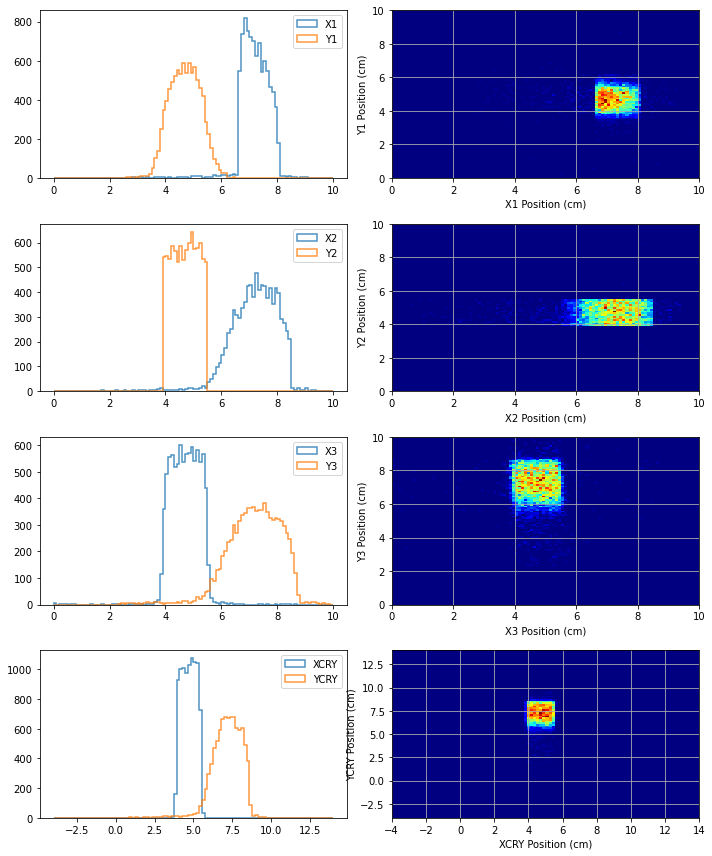

In [5]:
fig, ax = plt.subplots(4,2,figsize=(10, 12))
ax = ax.flatten()
ax[0].hist(xpos[:,1],range= range_chamber[0], bins=bins2d[0], label='X1', **opt_hist)
ax[0].hist(xpos[:,0],range= range_chamber[1], bins=bins2d[1], label='Y1', **opt_hist)
ax[0].legend()
ax[1].hist2d(xpos[:,1], xpos[:,0],range = range_chamber, **opts_2d)
ax[1].set_xlabel('X1 Position (cm)')
ax[1].set_ylabel('Y1 Position (cm)')
ax[1].grid()

ax[2].hist(xpos[:,3],range= range_chamber[0], bins=bins2d[0], label='X2', **opt_hist)
ax[2].hist(xpos[:,2],range= range_chamber[1], bins=bins2d[1], label='Y2', **opt_hist)
ax[2].legend()
ax[3].hist2d(xpos[:,3], xpos[:,2],range = range_chamber, **opts_2d)
ax[3].set_xlabel('X2 Position (cm)')
ax[3].set_ylabel('Y2 Position (cm)')
ax[3].grid()

ax[4].hist(xpos[:,4],range= range_chamber[0], bins=bins2d[0], label='X3', **opt_hist)
ax[4].hist(xpos[:,5],range= range_chamber[1], bins=bins2d[1], label='Y3', **opt_hist)
ax[4].legend()
ax[5].hist2d(xpos[:, 4], xpos[:, 5],range = range_chamber, **opts_2d)
ax[5].set_xlabel('X3 Position (cm)')
ax[5].set_ylabel('Y3 Position (cm)')
ax[5].grid()

ax[6].hist(xcry,range= (range_chamber[0][0]-4,range_chamber[0][1]+4), bins=bins2d[0], label='XCRY', **opt_hist)
ax[6].hist(ycry,range= (range_chamber[1][0]-4, range_chamber[1][1]+4), bins=bins2d[1], label='YCRY', **opt_hist)
ax[6].legend()
ax[7].hist2d(xcry, ycry,range =  ((range_chamber[0][0]-4,range_chamber[0][1]+4),(range_chamber[1][0]-4, range_chamber[1][1]+4)), **opts_2d)
ax[7].set_xlabel('XCRY Position (cm)')
ax[7].set_ylabel('YCRY Position (cm)')
ax[7].grid()

plt.tight_layout()
plt.show()

# Thetas

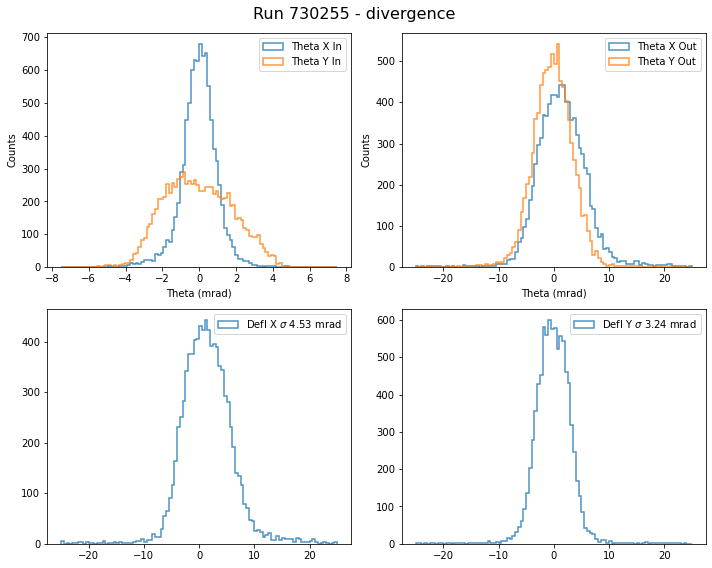

In [6]:
fig, ax = plt.subplots(2,2, figsize=(10, 8))
ax= ax.flatten()
fig.suptitle(f'Run {run_number} - divergence ', fontsize=16)

ax[0].hist(theta_x_in*1e3, bins=100, range=(-7.5, 7.5), label='Theta X In', **opt_hist)
ax[0].hist(theta_y_in*1e3, bins=100, range=(-7.5, 7.5), label='Theta Y In', **opt_hist)
ax[0].set_xlabel('Theta (mrad)')
ax[0].set_ylabel('Counts')

ax[1].hist(theta_x_out*1e3, bins=100, range=(-25, 25), label='Theta X Out', **opt_hist)
ax[1].hist(theta_y_out*1e3, bins=100, range=(-25, 25), label='Theta Y Out', **opt_hist)
ax[1].set_xlabel('Theta (mrad)')
ax[1].set_ylabel('Counts')

Defl_x = (theta_x_out-theta_x_in)*1e3
Defl_y = (theta_y_out-theta_y_in)*1e3
logi_deflx = (Defl_x >-25) & (Defl_x <25)
logi_defly = (Defl_y >-25) & (Defl_y <25)
ax[2].hist(Defl_x[logi_deflx], bins=100, range=(-25, 25), label=f'Defl X $\sigma$ {np.std(Defl_x[logi_deflx]):.2f} mrad', **opt_hist)
ax[3].hist(Defl_y[logi_defly], bins=100, range=(-25, 25), label=f'Defl Y $\sigma$ {np.std(Defl_y[logi_defly]):.2f} mrad', **opt_hist)

if CutTheta:
    ax[0].axvline(-theta_cut*1e3, c = 'r', ls = '--')
    ax[0].axvline(theta_cut*1e3, c = 'r', ls = '--', label = f'theta cut : $\pm${theta_cut*1e6:.2f} urad')
for a in ax:
    a.legend()
plt.tight_layout()
plt.show()

# Signals

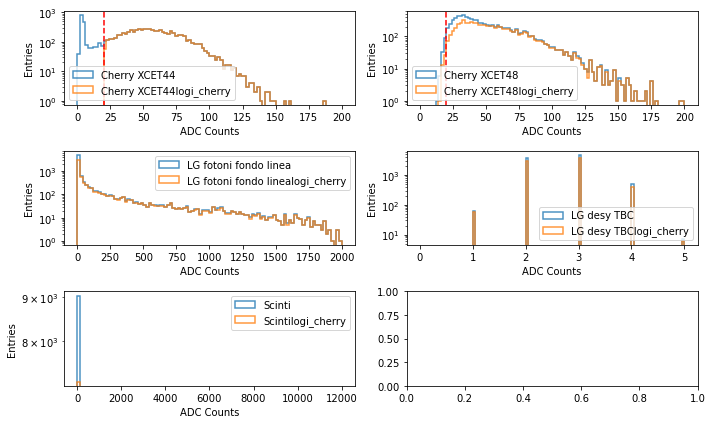

In [7]:
fig, ax = plt.subplots(3,2,figsize=(10, 6))
ax = ax.flatten()

label = ['Cherry XCET44', 'Cherry XCET48', 'LG fotoni fondo linea', 'LG desy TBC', 'Scinti']
ranges_Ph = [
    (0, 200),
    (0, 200),
    (0, 2000),
    (0, 5),
    (0, 12000)
]

for i in range(5):
    ax[i].hist(ph[:,i],range=ranges_Ph[i], bins=100, label=label[i], **opt_hist)
    ax[i].set_xlabel('ADC Counts')
    ax[i].set_ylabel('Entries')
    ax[i].legend()
    ax[i].grid()
    ax[i].set_yscale('log')
for i in range(5):
    ax[i].hist(ph[:,i][ph_cherry1>th_cherry1],range=ranges_Ph[i], bins=100, label=label[i]+ 'logi_cherry', **opt_hist)
    ax[i].set_xlabel('ADC Counts')
    ax[i].set_ylabel('Entries')
    ax[i].legend()
    ax[i].grid()
    ax[i].set_yscale('log')
    
ax[0].axvline(th_cherry1, color='red', linestyle='--', label='Threshold Cherry 1')
ax[1].axvline(th_cherry2, color='red', linestyle='--', label='Threshold Cherry 2')
plt.tight_layout()
plt.show()

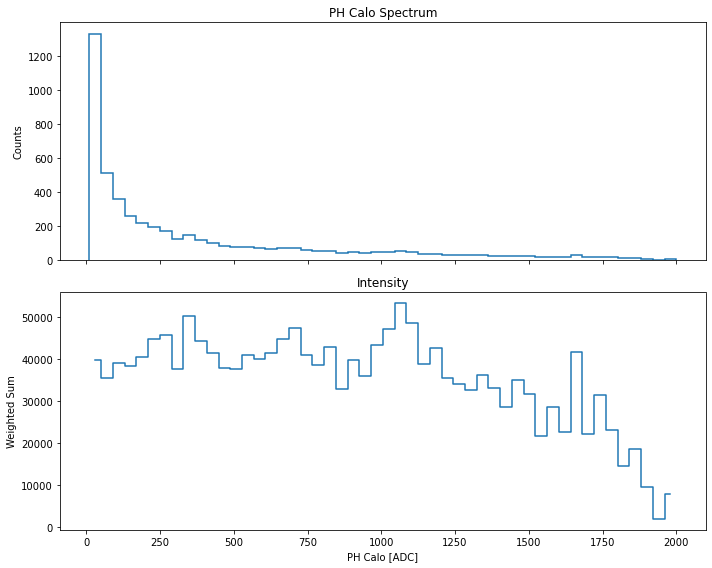

In [8]:
fig, ax = plt.subplots(2, figsize=(10, 8), sharex=True)

# Parametri istogramma
bins = 50
opt_hist = dict(histtype='step', linewidth=1.5)
rng_plot_calo=(10,ranges_Ph[2][1])

# === Primo istogramma: distribuzione originale ===
ax[0].hist(ph_calo_photon, bins=bins, range=rng_plot_calo, **opt_hist)
ax[0].set_title("PH Calo Spectrum")
ax[0].set_ylabel("Counts")

# === Secondo istogramma: PH × centro del bin ===
counts, bin_edges = np.histogram(ph_calo_photon, bins=bins, range=rng_plot_calo)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
weighted = counts * bin_centers

ax[1].step(bin_centers, weighted, where='mid')
ax[1].set_title("Intensity")
ax[1].set_xlabel("PH Calo [ADC]")
ax[1].set_ylabel("Weighted Sum")

plt.tight_layout()
plt.show()


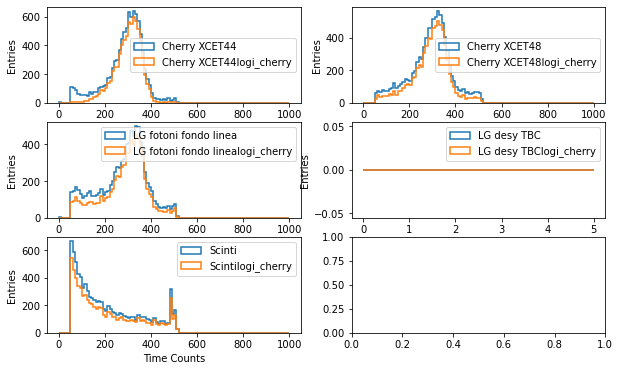

In [9]:
fig, ax = plt.subplots(3,2,figsize=(10, 6))
ax = ax.flatten()

label = ['Cherry XCET44', 'Cherry XCET48', 'LG fotoni fondo linea', 'LG desy TBC', 'Scinti']
ranges_time = [(0, 1000), (0, 1000), (0, 1000), (0, 5), (0, 1000)]
for i in range(5):
    ax[i].hist(tm[:,i],range=ranges_time[i], bins=100, label=label[i], **opt_hist)
    ax[i].set_xlabel('Time Counts')
    ax[i].set_ylabel('Entries')
    ax[i].legend()
    ax[i].grid()
for i in range(5):
    ax[i].hist(tm[:,i][ph_cherry1>th_cherry1],range=ranges_time[i], bins=100, label=label[i]+ 'logi_cherry', **opt_hist)
    ax[i].set_xlabel('Time Counts')
    ax[i].set_ylabel('Entries')
    ax[i].legend()
    ax[i].grid()

## Time difference (signal-cherry)

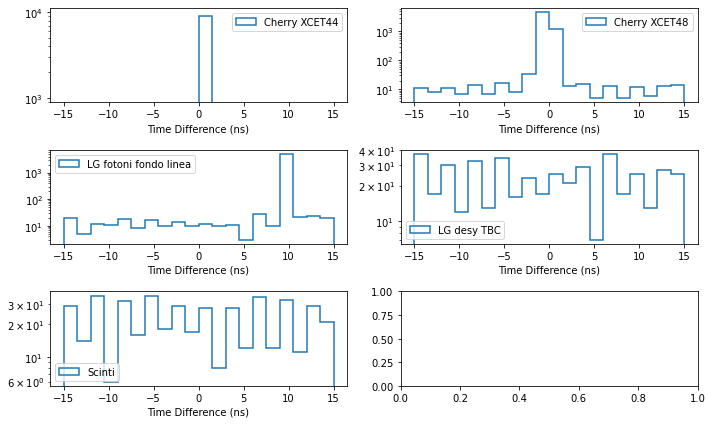

In [10]:
fig, ax = plt.subplots(3,2,figsize=(10, 6))
ax = ax.flatten()

for i in range(5):
    ax[i].hist(tm[:,i]-tm[:,0],range=(-15,15),bins=20, label=label[i], **opt_hist)
    ax[i].set_xlabel('Time Difference (ns)')
    ax[i].legend()
    ax[i].set_yscale('log')
plt.tight_layout()
plt.show()

## charge and cluster on S3


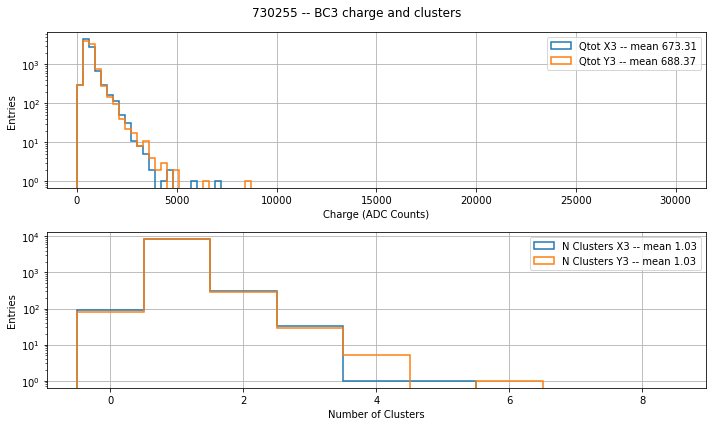

In [11]:
fig, ax = plt.subplots(2,1,figsize=(10, 6))
fig.suptitle(f'{run_number} -- BC3 charge and clusters')
ax[0].hist(qtot[:,0], range=(0, 30000), bins=100, label=f'Qtot X3 -- mean {np.mean(qtot[:,0]):.2f}', **opt_hist)
ax[0].hist(qtot[:,1], range=(0, 30000), bins=100, label=f'Qtot Y3 -- mean {np.mean(qtot[:,1]):.2f}', **opt_hist)
ax[0].set_xlabel('Charge (ADC Counts)')
ax[0].set_ylabel('Entries')
ax[1].hist(nclu[:,0], bins=np.arange(-0.5,round(np.max(nclu[:,0]))+0.5, 1), label=f'N Clusters X3 -- mean {np.mean(nclu[:,0]):.2f}', **opt_hist)
ax[1].hist(nclu[:,1], bins=np.arange(-0.5,round(np.max(nclu[:,1]))+0.5, 1), label=f'N Clusters Y3 -- mean {np.mean(nclu[:,1]):.2f}', **opt_hist)
ax[1].set_xlabel('Number of Clusters')
ax[1].set_ylabel('Entries')
for a in ax:
    a.legend()
    a.grid()
    a.set_yscale('log')

plt.tight_layout()
plt.show()

## Correlazione Time Ph

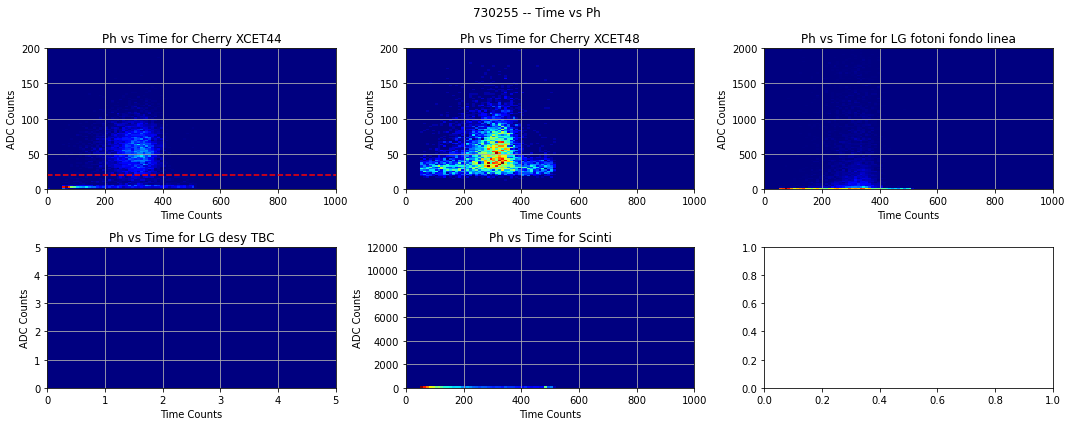

In [12]:
# hist 2d Ph[:,i] vs tm[:,i]
fig, ax = plt.subplots(2, 3, figsize=(15, 6))
fig.suptitle(f'{run_number} -- Time vs Ph')
ax = ax.flatten()
for i in range(5):
    ax[i].hist2d(tm[:, i],ph[:, i], range=[ranges_time[i],ranges_Ph[i]],**opts_2d)
    ax[i].set_xlabel('Time Counts')
    ax[i].set_ylabel('ADC Counts')
    ax[i].set_title(f'Ph vs Time for {label[i]}')
    ax[i].grid()

ax[0].axhline(th_cherry1, color='red', linestyle='--', label='Threshold Cherry 1')
plt.tight_layout()
plt.show()

### Cluster and Qtot with logi [ph_cherry1>th_cherry1]

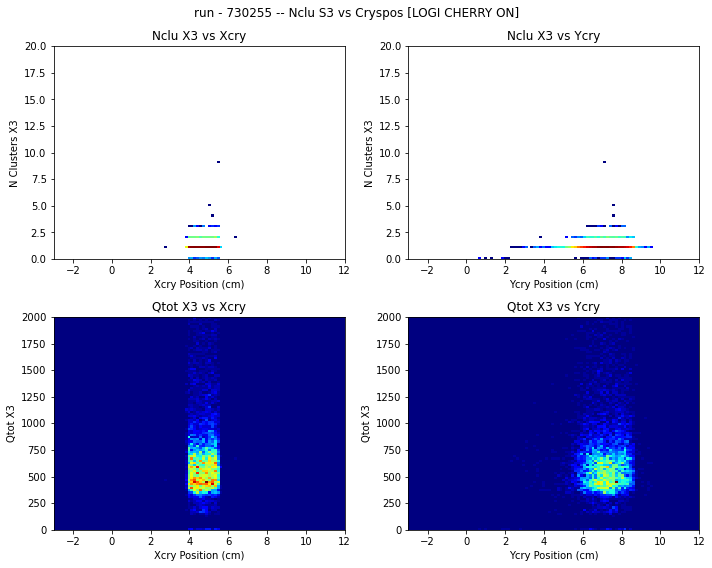

In [13]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle(f'run - {run_number} -- Nclu S3 vs Cryspos [LOGI CHERRY ON]')
ax = ax.flatten()
ax[0].set_title('Nclu X3 vs Xcry')
ax[0].hist2d(xcry[(ph_cherry1>th_cherry1) & (((theta_x_in)**2 + (theta_y_in)**2)<theta_cut)], nclu[:,0][(ph_cherry1>th_cherry1) & (((theta_x_in)**2 + (theta_y_in)**2)<theta_cut)],range =((-3,12),(0,20)),norm= mpl.colors.LogNorm(),**opts_2d)
ax[0].set_xlabel('Xcry Position (cm)')
ax[0].set_ylabel('N Clusters X3')
ax[1].set_title('Nclu X3 vs Ycry')
ax[1].hist2d(ycry[(ph_cherry1>th_cherry1) & (((theta_x_in)**2 + (theta_y_in)**2)<theta_cut)], nclu[:,0][(ph_cherry1>th_cherry1) & (((theta_x_in)**2 + (theta_y_in)**2)<theta_cut)],range =((-3,12),(0,20)),norm= mpl.colors.LogNorm(),**opts_2d)
ax[1].set_xlabel('Ycry Position (cm)')
ax[1].set_ylabel('N Clusters X3')


ax[2].set_title('Qtot X3 vs Xcry')
ax[2].hist2d(xcry[(ph_cherry1>th_cherry1) & (((theta_x_in)**2 + (theta_y_in)**2)<theta_cut)], qtot[:,0][(ph_cherry1>th_cherry1) & (((theta_x_in)**2 + (theta_y_in)**2)<theta_cut)],range =((-3,12),(0,2000)),**opts_2d)
ax[2].set_xlabel('Xcry Position (cm)')
ax[2].set_ylabel('Qtot X3')
ax[3].set_title('Qtot X3 vs Ycry')
ax[3].hist2d(ycry[(ph_cherry1>th_cherry1) & (((theta_x_in)**2 + (theta_y_in)**2)<theta_cut)], qtot[:,0][(ph_cherry1>th_cherry1) & (((theta_x_in)**2 + (theta_y_in)**2)<theta_cut)],range =((-3,12),(0,2000)),**opts_2d)
ax[3].set_xlabel('Ycry Position (cm)')
ax[3].set_ylabel('Qtot X3')

plt.tight_layout()
plt.show()

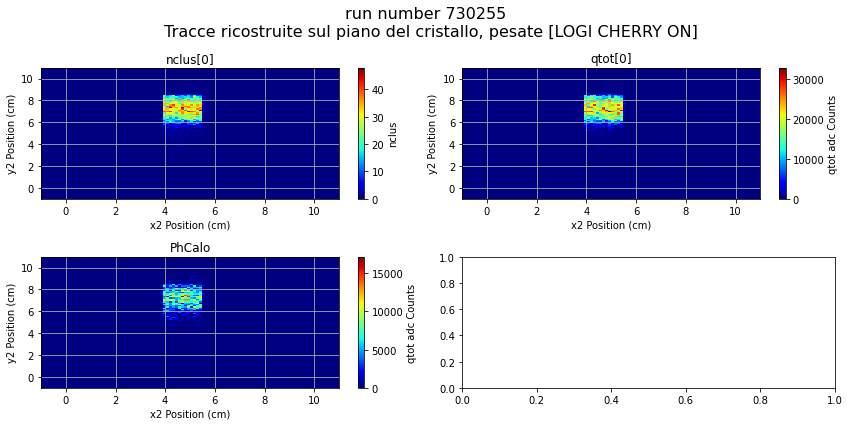

In [14]:
fig, ax = plt.subplots(2,2,figsize=(12, 6))
ax = ax.flatten()
fig.suptitle(f"run number {run_number} \n Tracce ricostruite sul piano del cristallo, pesate [LOGI CHERRY ON]", fontsize = 16)

ax[0].set_title('nclus[0]')
hh_clu = ax[0].hist2d(x2[(ph_cherry1>th_cherry1) & (((theta_x_in)**2 + (theta_y_in)**2)<theta_cut)], y2[(ph_cherry1>th_cherry1) & (((theta_x_in)**2 + (theta_y_in)**2)<theta_cut)],range = ((-1,11),(-1,11)), weights = nclu[:,0][(ph_cherry1>th_cherry1) & (((theta_x_in)**2 + (theta_y_in)**2)<theta_cut)], **opts_2d)
ax[0].set_xlabel('x2 Position (cm)')
ax[0].set_ylabel('y2 Position (cm)')
ax[0].grid()
plt.colorbar(hh_clu[3], ax=ax[0], label='nclus')

ax[1].set_title('qtot[0]')
hh_qtot = ax[1].hist2d(x2[(ph_cherry1>th_cherry1) & (((theta_x_in)**2 + (theta_y_in)**2)<theta_cut)], y2[(ph_cherry1>th_cherry1) & (((theta_x_in)**2 + (theta_y_in)**2)<theta_cut)],range = ((-1,11),(-1,11)), weights = qtot[:,0][(ph_cherry1>th_cherry1) & (((theta_x_in)**2 + (theta_y_in)**2)<theta_cut)], **opts_2d)
ax[1].set_xlabel('x2 Position (cm)')
ax[1].set_ylabel('y2 Position (cm)')
ax[1].grid()
plt.colorbar(hh_qtot[3], ax=ax[1], label='qtot adc Counts')

ax[2].set_title('PhCalo')
hh_qtot = ax[2].hist2d(x2[(ph_cherry1>th_cherry1) & (((theta_x_in)**2 + (theta_y_in)**2)<theta_cut)], y2[(ph_cherry1>th_cherry1) & (((theta_x_in)**2 + (theta_y_in)**2)<theta_cut)],range = ((-1,11),(-1,11)), weights = ph_calo_photon[(ph_cherry1>th_cherry1) & (((theta_x_in)**2 + (theta_y_in)**2)<theta_cut)], **opts_2d)
ax[2].set_xlabel('x2 Position (cm)')
ax[2].set_ylabel('y2 Position (cm)')
ax[2].grid()
plt.colorbar(hh_qtot[3], ax=ax[2], label='qtot adc Counts')

plt.tight_layout()
plt.show()

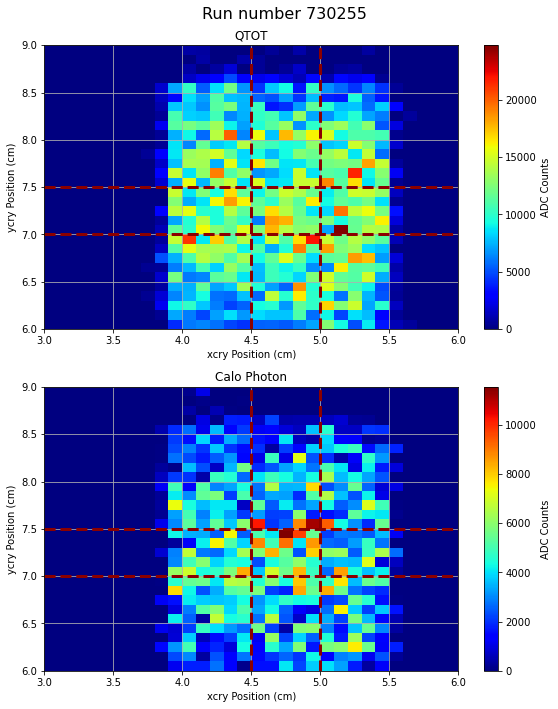

Δx = 0.500 cm, Δy = 0.500 cm, Area = 0.250 cm²


In [15]:
# Definizione tagli per ogni run
cuts = {}
if run_number in [730245, 730224, 730247,730250,730251,730253]: 
    cuts = { 
        730245 : {'x_cry_cut': [4.7, 5.2], 'y_cry_cut': [4.65, 5.15]},
        730224 : {'x_cry_cut': [4.7, 5.2], 'y_cry_cut': [4.65, 5.15]},
        730247 : {'x_cry_cut': [4.6, 5.1], 'y_cry_cut': [4.7, 5.2]},
        730250: {'x_cry_cut': [4.6, 5.1], 'y_cry_cut': [4.7, 5.2]},
        730251: {'x_cry_cut': [4.6, 5.1], 'y_cry_cut': [4.7, 5.2]},
        730253: {'x_cry_cut': [4.5, 5], 'y_cry_cut': [7, 7.5]},
    }
else:
    cuts[run_number] = {'x_cry_cut': [4.5, 5], 'y_cry_cut': [7, 7.5]} #{'x_cry_cut': [4.5, 5.2], 'y_cry_cut': [4.5, 5.2]}

# Recupera tagli corretti per run_number
x_cry_cut = cuts[run_number]['x_cry_cut']
y_cry_cut = cuts[run_number]['y_cry_cut']

# Plot
fig, ax = plt.subplots(2, 1, figsize=(8, 10))
fig.suptitle(f"Run number {run_number}", fontsize=16)
# Cristallo
hh_x = ax[0].hist2d(xcry[(ph_cherry1 > th_cherry1) & (((theta_x_in)**2 + (theta_y_in)**2)<theta_cut)], ycry[(ph_cherry1 > th_cherry1) & (((theta_x_in)**2 + (theta_y_in)**2)<theta_cut)],
                    range=((3, 6), (6, 9)), weights=qtot[:, 0][(ph_cherry1 > th_cherry1) & (((theta_x_in)**2 + (theta_y_in)**2)<theta_cut)],
                    cmap=mycmap, bins=30)
ax[0].set_xlabel('xcry Position (cm)')
ax[0].set_ylabel('ycry Position (cm)')
ax[0].grid()
ax[0].set_title('QTOT')
ax[0].axvline(x=x_cry_cut[0], color='darkred', linestyle='--', lw = 3)
ax[0].axvline(x=x_cry_cut[1], color='darkred', linestyle='--', lw = 3)
ax[0].axhline(y=y_cry_cut[0], color='darkred', linestyle='--', lw = 3)
ax[0].axhline(y=y_cry_cut[1], color='darkred', linestyle='--', lw = 3)
plt.colorbar(hh_x[3], ax=ax[0], label='ADC Counts')

hh_x = ax[1].hist2d(xcry[(ph_cherry1 > th_cherry1) & (((theta_x_in)**2 + (theta_y_in)**2)<theta_cut)], ycry[(ph_cherry1 > th_cherry1) & (((theta_x_in)**2 + (theta_y_in)**2)<theta_cut)],
                    range=((3, 6), (6, 9)), weights=ph_calo_photon[(ph_cherry1 > th_cherry1) & (((theta_x_in)**2 + (theta_y_in)**2)<theta_cut)],
                    cmap=mycmap, bins=30)
ax[1].set_xlabel('xcry Position (cm)')
ax[1].set_ylabel('ycry Position (cm)')
ax[1].grid()
ax[1].set_title('Calo Photon')
ax[1].axvline(x=x_cry_cut[0], color='darkred', linestyle='--', lw = 3)
ax[1].axvline(x=x_cry_cut[1], color='darkred', linestyle='--', lw = 3)
ax[1].axhline(y=y_cry_cut[0], color='darkred', linestyle='--', lw = 3)
ax[1].axhline(y=y_cry_cut[1], color='darkred', linestyle='--', lw = 3)
plt.colorbar(hh_x[3], ax=ax[1], label='ADC Counts')

plt.tight_layout()
plt.show()
x_min, x_max = x_cry_cut
y_min, y_max = y_cry_cut
dx, dy = x_max - x_min, y_max - y_min
print(f"Δx = {dx:.3f} cm, Δy = {dy:.3f} cm, Area = {dx * dy:.3f} cm²")


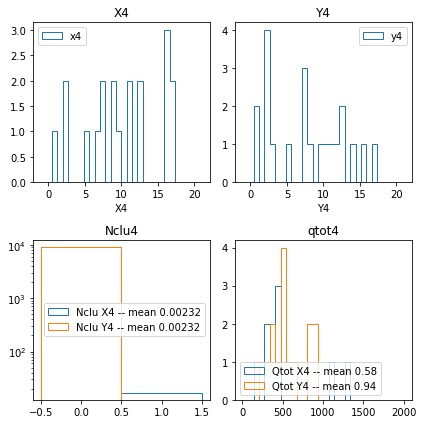

In [16]:
if run_number >730198:
    fig, ax = plt.subplots(2,2, figsize = (6,6))
    ax = ax.flatten()
    x4 = xpos[:,6]
    y4 = xpos[:,7]


    ax[0].hist(x4, bins = 30, range = (-1,21), histtype = 'step', label = 'x4')
    ax[0].set_title('X4')
    ax[0].set_xlabel('X4')
    ax[1].hist(y4, bins = 30, range = (-1,21), histtype = 'step', label = 'y4')
    ax[1].set_title('Y4')
    ax[1].set_xlabel('Y4')

    ax[2].hist(nclu[:,2], bins=np.arange(-0.5,round(np.max(nclu[:,2]))+0.5, 1), histtype = 'step', label = f'Nclu X4 -- mean {np.mean(nclu[:,2]):.5f}')
    ax[2].hist(nclu[:,3], bins=np.arange(-0.5,round(np.max(nclu[:,3]))+0.5, 1), histtype = 'step', label = f'Nclu Y4 -- mean {np.mean(nclu[:,3]):.5f}')
    ax[2].set_title('Nclu4')
    ax[2].set_yscale('log') 

    ax[3].hist(qtot[:,2], bins = 30, range = (10,2000), histtype = 'step', label = f'Qtot X4 -- mean {np.mean(qtot[:,2]):.2f}')
    ax[3].hist(qtot[:,3], bins = 30, range = (10,2000), histtype = 'step', label = f'Qtot Y4 -- mean {np.mean(qtot[:,3]):.2f}')
    ax[3].set_title('qtot4')

for a in ax:
    a.legend()
    
plt.tight_layout()
plt.show()